# NBA Team Ratings, Pt. 1

For each game, we observe the number of points, possessions, home court, and the teams involved.
Then, for each side of the court, we model the points scored (normalized by possessions) as a normal distribution with mean determined by the teams along with home court.

\begin{align}
x_i &\thicksim \mathcal{N}\left(\frac{\text{poss}_i}{100} \left( \mu + \text{off}_i - \text{def}_i + \delta_\text{home} \text{home} \right), \frac{\text{poss}_i}{100}\sigma_{\text{game}}^2 \right) \notag \\
\text{where } x_i &\equiv \text{points scored in the }i^\text{th} \text{ game} \notag \\
\text{poss}_i &\equiv \text{possessions in the }i^\text{th} \text{ game} \notag \\
\delta_\text{home} &\equiv \begin{cases} 1 & \text{if home team is on offense} \\ -1 & \text{otherwise} \end{cases} \notag \\
\mu &\equiv \text{league average scoring rate per 100 possessions} \notag
\end{align}

This model has four parameters of interest:
1. $ \overrightarrow{\text{off}} $, the points scored per 100 possessions above league average for each team
2. $ \overrightarrow{\text{def}} $, the points allowed per 100 possessions above league average for each team
3. $ \text{home} $, the points scored per 100 possessions above league average by the home team
4. $ \sigma_{\text{game}} $, the variance for the number of points scored per 100 possessions

These paremeters each have a prior distribution (since we're being Bayesian about it):

\begin{align}
    \overrightarrow{\text{off}} &\thicksim \mathcal{N}(0, \sigma_{\text{off}} ^ 2) \notag \\
    \overrightarrow{\text{def}} &\thicksim \mathcal{N}(0, \sigma_{\text{def}} ^ 2) \notag \\
    \text{home} &\thicksim \text{Gamma}(1.5, 0.5) \notag \\
    \sigma_{\text{game}} &\thicksim \text{Gamma}(5, 2) \notag
\end{align}

Note that each prior has its own set of parameters, aka hyperparameters, and specifically, that the priors for $ \overrightarrow{\text{off}} $ and $ \overrightarrow{\text{def}} $ have parameters with their own priors, aka hyperpriors.
The $ \text{home} $ and $ \sigma_{\text{game}} $ parameters use a Gamma prior.
This distribution is conveniently continuous and positive, making it a common one for the prior of a positive parameter like the standard deviation.
For that reason, I've also used it for the two hyperpriors:

\begin{align}
    \sigma_{\text{off}} &\thicksim \text{Gamma}(2, 0.5) \notag \\
    \sigma_{\text{def}} &\thicksim \text{Gamma}(1.5, 0.4) \notag \\
\end{align}

I haven't been too careful with setting these priors since this model is mostly for demonstration, but I've run it on the 2019 NBA Regular Season:

In [1]:
import pymc3 as pm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from pynba import halfgames_from_file, team_id_to_abb, plot_ratings, use_blackontrans_style


league = "nba"
year = 2019
season_type = "Regular Season"

In [2]:
halfgames = halfgames_from_file(league, year, season_type)

In [3]:
n_teams = halfgames["off_team_id"].unique().shape[0]
team_id_to_team_ind = {
    team_id: team_ind
    for team_ind, team_id in enumerate(halfgames["off_team_id"].unique())
}
team_id_to_team_abb = team_id_to_abb(league, year)
team_abb_to_team_id = {
    team_abb: team_id
    for team_id, team_abb in team_id_to_team_abb.items()
}
team_ind_to_team_abb = {
    team_ind: team_id_to_team_abb[team_id]
    for team_id, team_ind in team_id_to_team_ind.items()
}
points_mu = halfgames["points_scored"].sum() / halfgames["possession_num"].sum() * 100
off_index = (
    halfgames["off_team_id"].map(team_id_to_team_ind).to_numpy()
)
def_index = (
    halfgames["def_team_id"].map(team_id_to_team_ind).to_numpy()
)
home_index = (
    (halfgames["off_team_id"] != halfgames["home_team_id"])
    .to_numpy()
    .astype(int)
) * 2 - 1


with pm.Model() as model:
    sigma_game = pm.Gamma("sigma_game", mu=5, sigma=2)
    sigma_off = pm.Gamma("sigma_off", mu=2, sigma=0.5)
    sigma_def = pm.Gamma("sigma_def", mu=1.5, sigma=0.4)
    home = pm.Gamma("home", mu=1.5, sigma=0.5)
    teams_off = pm.Normal("teams_off", mu=0, sigma=sigma_off, shape=n_teams)
    teams_def = pm.Normal("teams_def", mu=0, sigma=sigma_def, shape=n_teams)
    poss_norm = halfgames["possession_num"].to_numpy() / 100
    pm.Normal(
        "points",
        mu=poss_norm * (points_mu + teams_off[off_index] - teams_def[def_index] + home * home_index),
        sigma=poss_norm * sigma_game,
        observed=halfgames["points_scored"].to_numpy()
    )

In [4]:
with model:
    trace = pm.sample(
        draws=10000,
        init="adapt_diag",
        chains=4,
        random_seed=42,
        return_inferencedata=False,
    )

2021-05-17 21:47:06 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:sample @ 495 | INFO | Auto-assigning NUTS sampler...
2021-05-17 21:47:06 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:init_nuts @ 2081 | INFO | Initializing NUTS using adapt_diag...
2021-05-17 21:47:14 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:sample @ 556 | INFO | Multiprocess sampling (4 chains in 4 jobs)
2021-05-17 21:47:14 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:_print_step_hierarchy @ 232 | INFO | NUTS: [teams_def, teams_off, home, sigma_def, sigma_off, sigma_game]


2021-05-17 21:48:00 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:sample @ 628 | INFO | Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 46 seconds.


In [5]:
results = pd.DataFrame({
    "team": [team_ind_to_team_abb[ind] for ind in range(n_teams)],
    "net_scoring_above_average": trace["teams_off"].mean(0) + trace["teams_def"].mean(0),
    "off_scoring_above_average": trace["teams_off"].mean(0),
    "def_scoring_above_average": trace["teams_def"].mean(0),
    "league": league,
    "year": year,
    "season_type": season_type,
})

results.sort_values("net_scoring_above_average", ascending=False)

,team,net_scoring_above_average,off_scoring_above_average,def_scoring_above_average,league,year,season_type
4,MIL,6.210715,2.802680,3.408035,nba,2019,Regular Season
2,GSW,5.181949,4.292881,0.889067,nba,2019,Regular Season
15,TOR,4.262034,2.190613,2.071421,nba,2019,Regular Season
21,UTA,3.961912,0.298230,3.663683,nba,2019,Regular Season
17,HOU,3.784661,4.048864,-0.264203,nba,2019,Regular Season
29,POR,3.508986,3.373137,0.135849,nba,2019,Regular Season
22,DEN,3.437770,2.023928,1.413842,nba,2019,Regular Season
0,BOS,2.932447,1.154435,1.778012,nba,2019,Regular Season
3,OKC,2.686181,-0.140427,2.826608,nba,2019,Regular Season
8,IND,2.030188,-0.486166,2.516354,nba,2019,Regular Season


In addition to plotting the offensive and defensive ratings of each team, I've annotated the difference between each team's "raw" ratings and their modeled ones.
We can see that although the model is factoring in strength of schedule and home-court advantage, it's primary effect is "shrinking" the raw ratings.
This is due to the priors for each team rating, which make extreme values less likely.

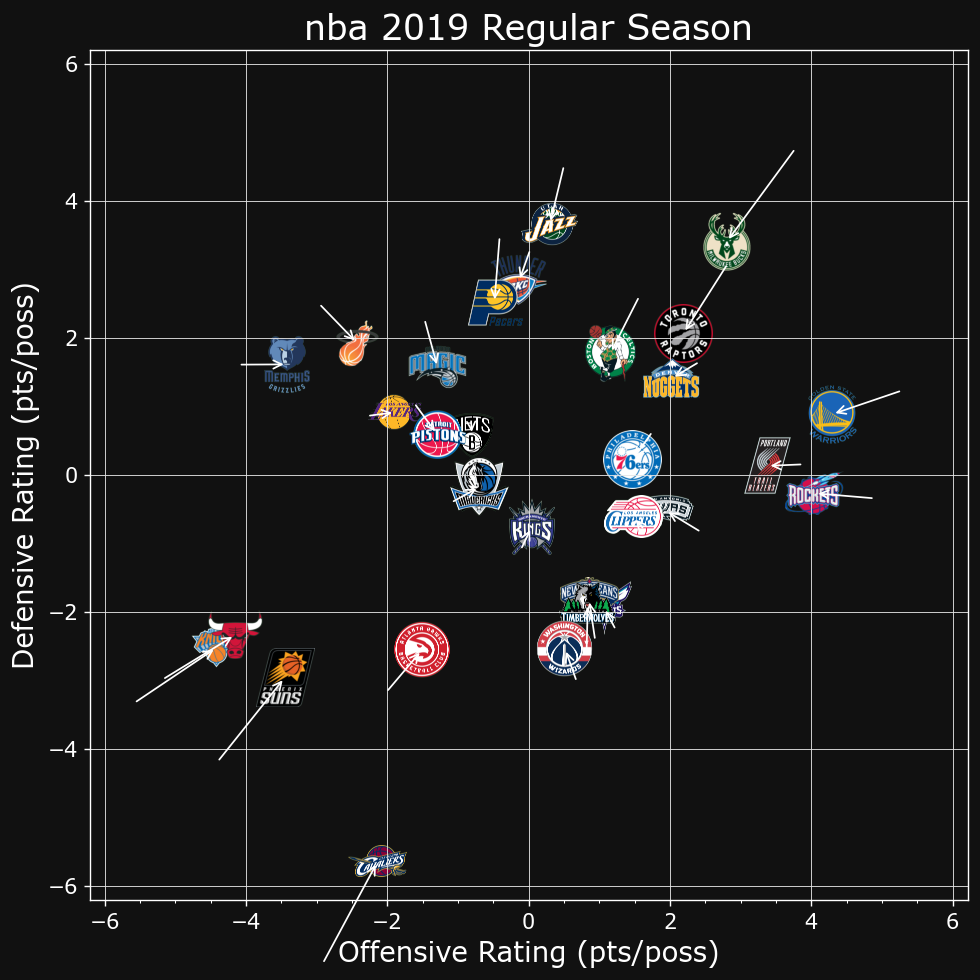

In [6]:
use_blackontrans_style()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
for team, off_aa, def_aa in zip(results["team"], results["off_scoring_above_average"], results["def_scoring_above_average"]):
    team_id = team_abb_to_team_id[team]
    filt = halfgames["off_team_id"] == team_id
    raw_off = halfgames.loc[filt, "points_scored"].sum() / halfgames.loc[filt, "possession_num"].sum() * 100 - points_mu
    filt = halfgames["def_team_id"] == team_id
    raw_def = points_mu - halfgames.loc[filt, "points_scored"].sum() / halfgames.loc[filt, "possession_num"].sum() * 100
    ax.annotate("", xy=(off_aa, def_aa), xytext=(raw_off, raw_def), arrowprops={"arrowstyle": "->", "color": "white"})
plot_ratings(results, ax)
